### DTFE implementation in python

In [1]:
from pyhull.delaunay import DelaunayTri
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def tetra_volume(_a,_b,_c,_d):
    v1 = _b-_a
    v2 = _c-_a
    v3 = _d-_a
    
    return np.abs(( v1[:,0]*v2[:,1]*v3[:,2] + v1[:,1]*v2[:,2]*v3[:,0] + v1[:,2]*v2[:,0]*v3[:,1] - 
                   (v1[:,2]*v2[:,1]*v3[:,0] + v1[:,1]*v2[:,0]*v3[:,2] + v1[:,0]*v2[:,2]*v3[:,1]) ))/6.0

In [3]:
#-----------------------------------------------------
#
#-----------------------------------------------------
def adjacent_volumes(_xyz, _verts):

    #--- Compute volumes for all tetrahedron
    a = _xyz[_verts[:,0],:]
    b = _xyz[_verts[:,1],:]
    c = _xyz[_verts[:,2],:]
    d = _xyz[_verts[:,3],:] 
    tetra_volumes = tetra_volume(a,b,c,d)
    
    #--- Array to store adjacent volumes to each vertex
    adj_volumes = np.zeros(_xyz.shape[0])
    
    #--- Iterate over the volumes corresponding to the vertices array
    for i, tet_i in enumerate(_verts):
        #--- Iterate over the vertices in this tetrahedron and add its adjacent volume
        for ver_j in tet_i:
            adj_volumes[ver_j] = adj_volumes[ver_j] + tetra_volumes[i]
        
    return adj_volumes

In [4]:
def write_to_file(_filename, _xyz, _den, _tri):
    
    f = open(_filename, 'w')
    f.write("{}\n".format(len(_den)))
    for i in range(len(_den)):
        ##f.write('{:11.4f},{:11.4f},{:11.4f},{:11.4f}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        f.write('{},{},{},{}\n'.format(_xyz[i,0], _xyz[i,1], _xyz[i,2], _den[i]))
        
    f.write("{}\n".format(len(_tri)))
    for item in _tri:
        f.write('{},{},{}\n'.format(item[0], item[1], item[2]))

    f.close()

In [5]:
#-------------------------------------
#  Constructs set of unique triplets. Note that this
#    is a destructive function as triplets are sorted first.
#
#  tris = [(0,1,2), (1,2,3), (2,3,4), (1,2,3), (1,2,3), (4,5,6), (2,1,0)]
#  clean = remove_repeated_triangles(tris)
#  print(clean)
#-------------------------------------
def remove_repeated_triangles(_tris):

    seti = set()
    for item in _tris:
        seti.add(tuple(np.sort(item)))

    return list(seti)

***
***

### Read particles from dataset and get subsample

In [6]:
PATH = '/Users/miguel/Projects/Data/MIP-2/'

pos = np.load(PATH + 'run_150_sub.npy')

x = pos[:,0]
y = pos[:,1]
z = pos[:,2]

sub = ((x < 2000) * (y < 2000) * (z < 2000)) .nonzero()[0]
x = pos[sub,0]
y = pos[sub,1]
z = pos[sub,2]

In [7]:
xyz = []
for i in range(len(x)):
    xyz.append((x[i], y[i], z[i]))
xyz = np.asarray(xyz, dtype=np.float32)

### Compute Delaunay tessellation and DTFE densities

In [8]:
delau = DelaunayTri(xyz)

tri = np.asarray(delau.vertices, dtype=np.int32)

vol = adjacent_volumes(xyz, tri)

In [12]:
vol.shape

(1436,)

In [13]:
#--- Remove zeroes from volume
zer  = (vol ==0).nonzero()[0]
nzer = (vol != 0).nonzero()[0]
vol[zer] = np.min(vol[nzer])

#--- Compute DTFE density
den = (1.0 / vol) / 3.0

### Rescale comuted density for plotting

In [14]:
#--- Mean approximated density of a given tetrahedron in the box
#mean_vol = np.power(1.0/np.power(len(den),0.333),3)

#--- Only 
#print(">>> Before cleaning: ", len(sub))
#sub = (den < np.std(den)).nonzero()[0]
#print(">>> After cleaning:  ", len(sub))

In [15]:
size = np.power(den, 0.1)
size = size-np.min(size)
size = size / np.max(size)

In [16]:
write_to_file('test-2000.csv', xyz, size, tri)

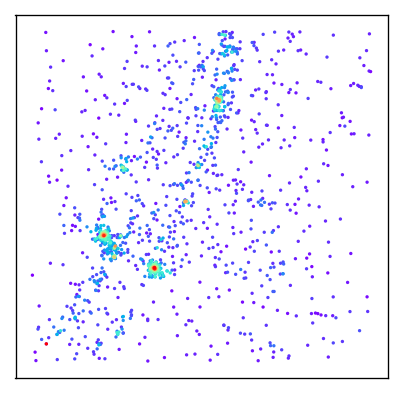

In [17]:
plt.figure(figsize=(4,4), dpi=120)
plt.xticks(())
plt.yticks(())

sorted = np.argsort(size)
plt.scatter(x[sorted],z[sorted], s=1, c=size[sorted]*255, cmap='rainbow')
plt.show()